In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).first()[0]
print(most_recent_date)


2017-08-23


The prior year starts at 2016-08-23


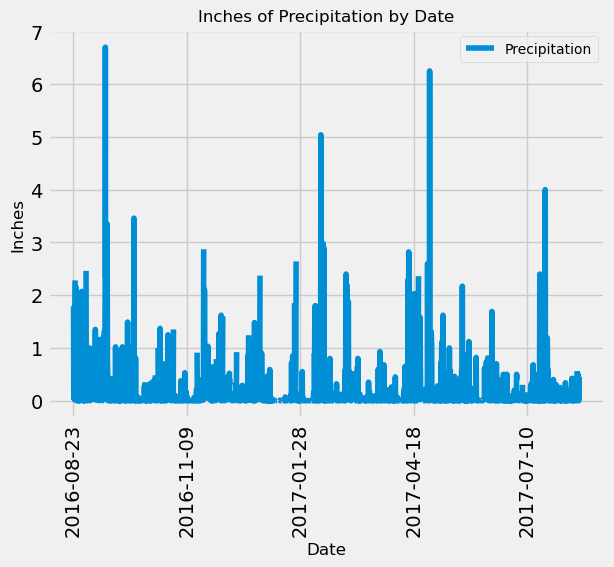

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
prior_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"The prior year starts at {prior_year}")

# Perform a query to retrieve the data and precipitation scores
d_and_p = (
    session.query(measurement.date, measurement.prcp)
    .filter(measurement.date >= prior_year)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
rain_data = pd.DataFrame(d_and_p, columns=["Date", "Precipitation"])

# Sort the dataframe by date
rain_data = rain_data.sort_values(by="Date")

# Use Pandas Plotting with Matplotlib to plot the data
rain_data.plot(x="Date", y="Precipitation", rot=90)
rain_data["Date"] = pd.to_datetime(rain_data["Date"])

plt.title("Inches of Precipitation by Date", fontsize=12)
plt.ylabel("Inches", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(["Precipitation"], loc="upper right", fontsize=10)

# save a copy of the figure
plt.savefig("images/precipitation.png")
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_data.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
ms = measurement.station
mt = measurement.tobs

print(f"The total number of stations is {session.query(func.count(station.station)).scalar()}.")

The total number of stations is 9.


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
mas = session.query(ms, func.count(ms)).group_by(ms).order_by(func.count(ms).desc()).all()
print("Station      Count of Observations")
for _ in mas:
    print(f"{_[0]}, {_[1]}")

most_active_name, most_active_count = most_active = (
    session.query(ms, func.count(ms)).group_by(ms).order_by(func.count(ms).desc()).first()
)
print(f"\nThe most active station is {most_active_name} with {most_active_count} measurements.")

Station      Count of Observations
USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511

The most active station is USC00519281 with 2772 measurements.


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
high, low, average = (session.query(func.min(mt), func.max(mt), func.avg(mt)).filter(ms == most_active_name).first())
print(f"The lowest temperature is {low}, the highest temperature is {high}, and the average temperature is {average:.2f}.")


The lowest temperature is 85.0, the highest temperature is 54.0, and the average temperature is 71.66.


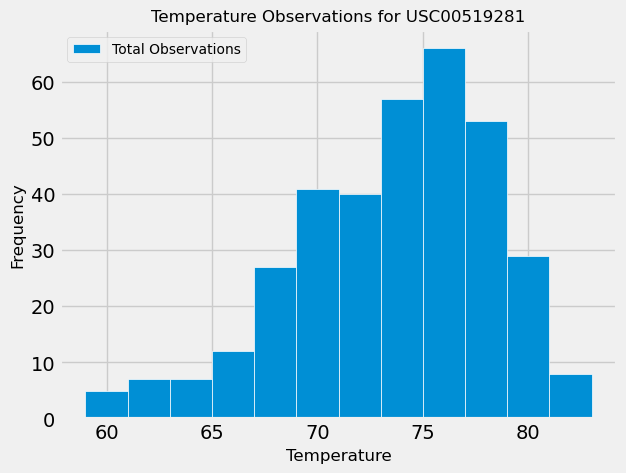

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12 = session.query(mt).filter(ms == most_active_name).filter(measurement.date >= prior_year).all()

# create dataframe
temp_data = pd.DataFrame(last_12, columns=["Temperature"])

# create plot
temp_data.plot.hist(bins=12, edgecolor="white")

# format 
plt.title("Temperature Observations for USC00519281", fontsize=12)
plt.xlabel("Temperature", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(["Total Observations"], loc="best", fontsize=10)

# save image 
plt.savefig("images/temperatures.png")
plt.show()

# Close Session

In [16]:
# Close Session
session.close()